In [1]:
import os
import numpy as np
import mne
from mne_bids import (
    find_matching_paths,
    read_raw_bids,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mne.stats import permutation_cluster_test

In [2]:
def plot_f_test(epochs, picks, conditions, condition_labels=['Condition 1', 'Condition 2']):
    epochs_ = epochs.copy().load_data()
    times = epochs_.times

    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    fig.suptitle("Channel : " + picks[0])

    line_color = 'grey'
    unit = 'mV'
    # Plot signals
    ds = []
    conditions_data = []
    for condition, condition_name  in zip(conditions, condition_labels):
        condition_data = epochs_[condition].get_data(picks=picks, units=unit)[:,0,:]
        conditions_data.append(condition_data)

        for epoch_data in condition_data:
            for t, data in zip(times, epoch_data):
                ds.append({'condition': condition_name, 'time': t, 'data': data})
        df = pd.DataFrame(ds)

    ax = axes[0]
    sns.lineplot(x='time', y='data', data=df, ax=ax, hue='condition', hue_order=condition_labels, palette='tab10')
    x_lims = ax.get_xlim()
    y_lims = ax.get_ylim()
    ax.vlines(0, y_lims[0]*2,  y_lims[1]*2, color=line_color)
    ax.hlines(0, x_lims[0]*2,  x_lims[1]*2, color=line_color)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.set_ylabel(f"Amplitude ({unit})")

    # Get original legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    hue_counts = {}
    for label, condition in zip(labels, conditions):
        hue_counts[label] = len(epochs_[condition])
    # Modify labels to include sample counts
    new_labels = [f"{label} (n={hue_counts[label]})" for label in labels]
    ax.legend(handles, new_labels, title="Condition")


    # Plot contrast
    ax = axes[1]
    diff = conditions_data[0].mean(axis=0) - conditions_data[1].mean(axis=0)
    sns.lineplot(x=times, y=diff, ax=ax, color='teal')
    x_lims = ax.get_xlim()
    y_lims = ax.get_ylim()
    ax.vlines(0, y_lims[0]*2,  y_lims[1]*2, color=line_color)
    ax.hlines(0, x_lims[0]*2,  x_lims[1]*2, color=line_color)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.set_ylabel(f"Amplitude difference ({unit})")


    # Plot permutation test
    ax = axes[2]
    threshold = None
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        conditions_data,
        n_permutations=1000,
        threshold=threshold,
        tail=1,
        n_jobs=None,
        out_type="mask",
    )

    h = None
    for i_c, c in enumerate(clusters):
        c = c[0]
        start = c.start
        stop = c.stop - 1
        if cluster_p_values[i_c] <= 0.05:
            h = ax.axvspan(times[start], times[stop], color="r", alpha=0.3)
        else:
            ax.axvspan(times[start], times[stop], color=(0.3, 0.3, 0.3), alpha=0.3)

    sns.lineplot(x=times, y=T_obs, ax=ax, color='green')
    if h is not None:
        ax.legend((h,), ("cluster p-value < 0.05",))
    ax.set_xlabel("time (s)")
    ax.set_ylabel("f-values")

    y_lims = ax.get_ylim()
    ax.vlines(0, y_lims[0]*2,  y_lims[1]*2, color=line_color)
    ax.set_ylim(y_lims)
    return fig

In [9]:
n_jobs = 12
bids_root = os.path.abspath("../..")
subjects = ["01", "02", "03", "04", "06"]

for subject in subjects:
    bids_path = find_matching_paths(
    subjects=subject, sessions="retrieval", tasks="mars", datatypes="ieeg", extensions="vhdr", root=bids_root
    )[0]
    raw = read_raw_bids(bids_path=bids_path, verbose=False)

    # bad annotations
    bad_annotation_path = str(bids_path.copy().fpath).replace("_ieeg.vhdr", "_annot.csv")
    bad_annotations = mne.read_annotations(bad_annotation_path)
    raw.set_annotations(raw.annotations + bad_annotations)


    # load events
    events_path = bids_path.copy().update(extension="tsv", suffix="events")
    df_events = pd.read_csv(events_path, sep="\t")
    df_events =  df_events[(df_events['correct'] == True) & (df_events['duration'] < 5)]
    print(subject)
    print(df_events[['condition', 'onset']].groupby('condition').count())

C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any electrodes.tsv associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any coordsystem.json associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any electrodes.tsv associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeW

01
               onset
condition           
Always            16
Current           18
Distant Futur      2
Distant Past       7
Futur              7
Never             19
Past               5
02
              onset
condition          
Always           10
Current           7
Distant Past      7
Never            12
Past              2


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any electrodes.tsv associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any coordsystem.json associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


03
              onset
condition          
Always            9
Current           9
Distant Past      4
Never            16
Past              5


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any electrodes.tsv associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any coordsystem.json associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


04
               onset
condition           
Always             5
Current           14
Distant Futur      8
Distant Past      12
Futur              4
Never              7
Past               9
06
               onset
condition           
Always            10
Current            7
Distant Futur      2
Distant Past       3
Never              3
Past               2


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any electrodes.tsv associated with sub-06_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-06\**\ieeg\sub-06_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3225215147.py:9: RuntimeWarning: Did not find any coordsystem.json associated with sub-06_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-06\**\ieeg\sub-06_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


In [11]:
df_events

,onset,duration,value,sample,cross_time,year,resp,correct_year,condition,correct,validation
0,52.781250,4.37098,2,108096,2.222847,1,C,1,Current,True,True
1,59.381348,4.66434,5,121613,2.221072,1,+1,2,Futur,True,True
2,65.812500,3.81678,2,134784,1.756835,1,C,1,Current,True,True
5,91.729980,4.03372,3,187863,2.274007,1,+2,4,Distant Futur,True,True
6,97.629395,3.45148,6,199945,1.864412,1,N,Never,Never,True,True
...,...,...,...,...,...,...,...,...,...,...,...
113,819.617676,2.43385,2,1678577,2.027611,4,C,4,Current,True,True
114,823.917969,1.71653,2,1687384,1.861769,4,C,4,Current,True,True
116,835.166992,4.26708,7,1710422,2.283468,4,-1,3,Past,True,True
117,841.501465,2.28261,6,1723395,2.051265,4,N,Never,Never,True,True


In [14]:
n_jobs = 12
bids_root = os.path.abspath("../..")

for subject in subjects:
    bids_path = find_matching_paths(
    subjects=subject, sessions="retrieval", tasks="mars", datatypes="ieeg", extensions="vhdr", root=bids_root
    )[0]
    raw = read_raw_bids(bids_path=bids_path, verbose=False)

    # bad annotations
    bad_annotation_path = str(bids_path.copy().fpath).replace("_ieeg.vhdr", "_annot.csv")
    bad_annotations = mne.read_annotations(bad_annotation_path)
    raw.set_annotations(raw.annotations + bad_annotations)


    # load events
    events_path = bids_path.copy().update(extension="tsv", suffix="events")
    df_events = pd.read_csv(events_path, sep="\t")
    df_events =  df_events[(df_events['correct'] == True) & (df_events['duration'] < 5)]
    events = df_events[['sample', 'duration', 'value']].values.astype(int)

    event_id = dict()
    for condition in df_events['condition'].unique():
        event_id[condition] =  df_events[df_events['condition'] == condition]['value'].values[0]


    if "HAD1" in raw.ch_names:
        picks = ['HAD1', 'HAD2', 'HPD1', 'HPD2']
    elif "HAG1" in raw.ch_names:
        picks = ['HAG1', 'HAG2', 'HPG1', 'HPG2']

    raw.load_data()
    # filter
    raw.filter(.5, 30, picks='seeg', fir_design='firwin', n_jobs=n_jobs, verbose=False)
    # remove power line 50 Hz and harmonics
    raw.notch_filter(np.arange(50, 251, 50),
                    picks='seeg', 
                    notch_widths=4,
                    n_jobs=n_jobs,
                    verbose=False)

    raw_seeg = raw.copy()
    good_channels = list(set(raw_seeg.ch_names) - set(raw_seeg.info['bads']) - set(['photodiode']))
    #raw_seeg.info['bads'] = []
    raw_seeg.set_eeg_reference(good_channels, ch_type='seeg')

    epochs = mne.Epochs(raw_seeg, events, event_id=event_id, tmin=-0.5, tmax=2, baseline=(-0.5, 0),  detrend=1, event_repeated='raise', reject_by_annotation=True).load_data()
    epochs.resample(250)
    for pick in picks:
        if pick in epochs.ch_names:
            for condition_label, condition,  in [('Futur', ["Futur", "Distant Futur"]), ('Past', ["Past", "Distant Past"])]:
                condition = [c for c in condition if c in epochs.event_id]
                if len(epochs[condition]):
                    print(f"Plotting {subject} {pick} {condition_label}")
                    conditions = [['Current'], condition]
                    fig = plot_f_test(epochs, [pick], conditions, condition_labels=['Current', condition_label])
                    fig.savefig(f"figures/{subject}_{pick}_{condition_label}.png", dpi=300)
                    plt.close(fig)
            else:
                print(f"Skipping {subject} {pick} {condition_label}, no epochs found for conditions {condition}")

C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any electrodes.tsv associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any coordsystem.json associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 1843200  =      0.000 ...   900.000 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 74 events and 5121 original time points ...
0 bad epochs dropped
Plotting 01 HAG1 Futur
Using a threshold of 4.241699
stat_fun(H1): min=2.770070285440088e-05 max=8.540498290490987
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2807.19it/s]


Plotting 01 HAG1 Past
Using a threshold of 4.195972
stat_fun(H1): min=4.93682708752274e-08 max=8.228760513374533
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2286.00it/s]


Skipping 01 HAG1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 01 HAG2 Futur
Using a threshold of 4.241699
stat_fun(H1): min=5.068294884126162e-08 max=10.347992522521608
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2939.57it/s]


Plotting 01 HAG2 Past
Using a threshold of 4.195972
stat_fun(H1): min=0.0002238920978917654 max=6.517485435161847
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2854.87it/s]


Skipping 01 HAG2 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 01 HPG1 Futur
Using a threshold of 4.241699
stat_fun(H1): min=6.196585737827941e-05 max=12.017146336827853
Running initial clustering …
Found 7 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3167.33it/s]


Plotting 01 HPG1 Past
Using a threshold of 4.195972
stat_fun(H1): min=6.109165603804938e-06 max=6.227790464781851
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3219.36it/s]


Skipping 01 HPG1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 01 HPG2 Futur
Using a threshold of 4.241699
stat_fun(H1): min=1.4996530661114916e-06 max=6.63240077572903
Running initial clustering …
Found 7 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2450.08it/s]


Plotting 01 HPG2 Past
Using a threshold of 4.195972
stat_fun(H1): min=1.5988020872757533e-08 max=9.475305401200577
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3078.74it/s]


Skipping 01 HPG2 Past, no epochs found for conditions ['Past', 'Distant Past']
Reading 0 ... 3276800  =      0.000 ...  1600.000 secs...


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any electrodes.tsv associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any coordsystem.json associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Applying a custom ('sEEG',) reference.
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 5121 original time points ...
0 bad epochs dropped
Plotting 02 HAD1 Past
Using a threshold of 4.600110
stat_fun(H1): min=5.254007319685685e-07 max=5.171547102481023
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2625.38it/s]


Skipping 02 HAD1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 02 HAD2 Past
Using a threshold of 4.600110
stat_fun(H1): min=6.06687441034378e-07 max=6.3117279915279765
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3349.24it/s]


Skipping 02 HAD2 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 02 HPD1 Past
Using a threshold of 4.600110
stat_fun(H1): min=2.4153373531142343e-07 max=6.694750613350225
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3373.94it/s]


Skipping 02 HPD1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 02 HPD2 Past
Using a threshold of 4.600110
stat_fun(H1): min=8.486033725535146e-06 max=11.261848414536264
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3393.86it/s]


Skipping 02 HPD2 Past, no epochs found for conditions ['Past', 'Distant Past']


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any electrodes.tsv associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any coordsystem.json associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 2863946  =      0.000 ...  1398.411 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
43 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 43 events and 5121 original time points ...
6 bad epochs dropped
Plotting 03 HAD1 Past
Using a threshold of 4.667193
stat_fun(H1): min=1.726185131746788e-09 max=11.058804974427536
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3333.50it/s]


Skipping 03 HAD1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 03 HAD2 Past
Using a threshold of 4.667193
stat_fun(H1): min=1.2105882599853936e-06 max=14.938541582952817
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3462.59it/s]


Skipping 03 HAD2 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 03 HPD1 Past
Using a threshold of 4.667193
stat_fun(H1): min=1.0681053661203161e-06 max=19.43685426053575
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2548.46it/s]


Skipping 03 HPD1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 03 HPD2 Past
Using a threshold of 4.667193
stat_fun(H1): min=2.946329875865343e-05 max=10.821853747179748
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2806.63it/s]


Skipping 03 HPD2 Past, no epochs found for conditions ['Past', 'Distant Past']


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any electrodes.tsv associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any coordsystem.json associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 5493832  =      0.000 ...  2682.535 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
59 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 59 events and 5121 original time points ...
2 bad epochs dropped
Plotting 04 HAD1 Futur
Using a threshold of 4.279344
stat_fun(H1): min=6.876224401352609e-08 max=3.5471100977271264
Running initial clustering …
Found 0 clusters


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3366104814.py:58: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Plotting 04 HAD1 Past
Using a threshold of 4.149097
stat_fun(H1): min=2.3645068105493602e-08 max=7.297110465595043
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3150.89it/s]


Skipping 04 HAD1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 04 HAD2 Futur
Using a threshold of 4.279344
stat_fun(H1): min=8.362476026658861e-05 max=3.487457448995892
Running initial clustering …
Found 0 clusters


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3366104814.py:58: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Plotting 04 HAD2 Past
Using a threshold of 4.149097
stat_fun(H1): min=2.5184510514900133e-06 max=8.723243772679623
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3433.15it/s]


Skipping 04 HAD2 Past, no epochs found for conditions ['Past', 'Distant Past']


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any electrodes.tsv associated with sub-06_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-06\**\ieeg\sub-06_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\117618805.py:8: RuntimeWarning: Did not find any coordsystem.json associated with sub-06_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-06\**\ieeg\sub-06_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 4916931  =      0.000 ...  2400.845 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 5121 original time points ...
7 bad epochs dropped
Plotting 06 HAG1 Futur
Using a threshold of 7.708647
stat_fun(H1): min=1.3104982368257056e-07 max=674.9528494161037
Running initial clustering …
Found 8 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2710.31it/s]


Plotting 06 HAG1 Past
Using a threshold of 5.591448
stat_fun(H1): min=2.5545227042815696e-09 max=11.776242248273425
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3754.91it/s]


Skipping 06 HAG1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 06 HAG2 Futur
Using a threshold of 7.708647
stat_fun(H1): min=4.7977361841616586e-06 max=530.6530924909433
Running initial clustering …
Found 9 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3022.30it/s]


Plotting 06 HAG2 Past
Using a threshold of 5.591448
stat_fun(H1): min=4.235839765361647e-07 max=9.107051468951898
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3992.04it/s]


Skipping 06 HAG2 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 06 HPG1 Futur
Using a threshold of 7.708647
stat_fun(H1): min=9.178930901444125e-08 max=1113.1719290290334
Running initial clustering …
Found 12 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3857.74it/s]


Plotting 06 HPG1 Past
Using a threshold of 5.591448
stat_fun(H1): min=3.30824169422365e-05 max=7.7539264323623955
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 999/999 [00:00<00:00, 3151.55it/s]


Skipping 06 HPG1 Past, no epochs found for conditions ['Past', 'Distant Past']
Plotting 06 HPG2 Futur
Using a threshold of 7.708647
stat_fun(H1): min=3.8682806840030754e-05 max=885.9686100685689
Running initial clustering …
Found 8 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2668.94it/s]


Plotting 06 HPG2 Past
Using a threshold of 5.591448
stat_fun(H1): min=2.3547112064567619e-07 max=5.40471961574253
Running initial clustering …
Found 0 clusters


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3366104814.py:58: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Skipping 06 HPG2 Past, no epochs found for conditions ['Past', 'Distant Past']


In [18]:
tmin = -1
tmax = 5
baseline = (-1, 0)

fr_bands = [[3,7],[15,40],[60,100]]
fr_bands_name = ['Theta','Beta','HpR']


n_jobs = 12
bids_root = os.path.abspath("../..")

for subject in subjects:
    bids_path = find_matching_paths(
    subjects=subject, sessions="retrieval", tasks="mars", datatypes="ieeg", extensions="vhdr", root=bids_root
    )[0]
    raw = read_raw_bids(bids_path=bids_path, verbose=False)

    # bad annotations
    bad_annotation_path = str(bids_path.copy().fpath).replace("_ieeg.vhdr", "_annot.csv")
    bad_annotations = mne.read_annotations(bad_annotation_path)
    raw.set_annotations(raw.annotations + bad_annotations)


    # load events
    events_path = bids_path.copy().update(extension="tsv", suffix="events")
    df_events = pd.read_csv(events_path, sep="\t")
    df_events =  df_events[(df_events['correct'] == True) & (df_events['duration'] < 5)]
    events = df_events[['sample', 'duration', 'value']].values.astype(int)

    event_id = dict()
    for condition in df_events['condition'].unique():
        event_id[condition] =  df_events[df_events['condition'] == condition]['value'].values[0]


    if "HAD1" in raw.ch_names:
        picks = ['HAD1', 'HAD2', 'HPD1', 'HPD2']
    elif "HAG1" in raw.ch_names:
        picks = ['HAG1', 'HAG2', 'HPG1', 'HPG2']

    raw.load_data()
    # filter
    raw.filter(.5, 40, picks='seeg', fir_design='firwin', n_jobs=n_jobs, verbose=False)
    # remove power line 50 Hz and harmonics
    raw.notch_filter(np.arange(50, 251, 50),
                    picks='seeg', 
                    notch_widths=4,
                    n_jobs=n_jobs,
                    verbose=False)

    raw_seeg = raw.copy()
    good_channels = list(set(raw_seeg.ch_names) - set(raw_seeg.info['bads']) - set(['photodiode']))
    #raw_seeg.info['bads'] = []
    raw_seeg.set_eeg_reference(good_channels, ch_type='seeg')

    epochs = mne.Epochs(raw_seeg, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=baseline, detrend=None, event_repeated='drop', reject_by_annotation=True).drop_bad()

    psd = epochs.compute_psd(fmin=0, fmax=50, tmin=0, tmax=tmax)
    df_psd = psd.to_data_frame()
    for ch_name in epochs.ch_names:
        try:
            df_psd[ch_name] = 10 * np.log10(df_psd[ch_name])
        except:
            pass

    group_conditions = []
    for condition in df_psd['condition'].values:
        if condition in ['Distant Past', 'Past']:
            group_conditions.append('Past')
        elif condition in ['Distant Futur', 'Futur']:
            group_conditions.append('Futur')
        else:
            group_conditions.append(condition)

    df_psd['group_condition'] = group_conditions


    try:
        fig, axes = plt.subplots(1, len(picks), figsize=(50, 5))

        for c,ch_name in enumerate(picks):
            ax = axes[c]
            sns.lineplot(ax=ax,
                        x="freq", y=ch_name,
                        hue="group_condition",
                        hue_order=['Past', 'Current', 'Futur'],
                        errorbar=('ci', 95),
                        data=df_psd)
            ax.set_xlim([1, 50])
            ax.set_title(ch_name)

            fig.savefig(f"figures/psd/{subject}.png", dpi=300)
            plt.close(fig)
    except Exception as e:
        print(f"Error processing {subject}: {e}")

C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any electrodes.tsv associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any coordsystem.json associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 1843200  =      0.000 ...   900.000 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 74 events and 12289 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 12289 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_psd['group_condition'] = group_conditions
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any electrodes.tsv associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any coordsystem.json associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, ver

Reading 0 ... 3276800  =      0.000 ...  1600.000 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 12289 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 38 events and 12289 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_psd['group_condition'] = group_conditions
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any electrodes.tsv associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any coordsystem.json associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, ver

Reading 0 ... 2863946  =      0.000 ...  1398.411 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
43 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 43 events and 12289 original time points ...
12 bad epochs dropped
Using data from preloaded Raw for 31 events and 12289 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_psd['group_condition'] = group_conditions
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any electrodes.tsv associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any coordsystem.json associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, ver

Reading 0 ... 5493832  =      0.000 ...  2682.535 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
59 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 59 events and 12289 original time points ...
3 bad epochs dropped
Using data from preloaded Raw for 56 events and 12289 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_psd['group_condition'] = group_conditions


Error processing 04: Could not interpret value `HPD1` for parameter `y`


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any electrodes.tsv associated with sub-06_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-06\**\ieeg\sub-06_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:16: RuntimeWarning: Did not find any coordsystem.json associated with sub-06_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-06\**\ieeg\sub-06_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 4916931  =      0.000 ...  2400.845 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 12289 original time points ...
15 bad epochs dropped
Using data from preloaded Raw for 12 events and 12289 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\ferat\AppData\Local\Temp\ipykernel_12600\3730851264.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_psd['group_condition'] = group_conditions


In [13]:
n_jobs = 12
bids_root = os.path.abspath("../..")
subjects = ["01", "02", "03", "04"]


for subject in subjects:
    bids_path = find_matching_paths(
        subjects=subject, sessions="retrieval", tasks="mars", datatypes="ieeg", extensions="vhdr", root=bids_root
    )[0]
    raw = read_raw_bids(bids_path=bids_path, verbose=False)

    # load events
    events_path = bids_path.copy().update(extension="tsv", suffix="events")
    df_events = pd.read_csv(events_path, sep="\t")
    df_events = df_events[(df_events['correct'] == True) & (df_events['duration'] < 5)]
    events = df_events[["sample", "duration", "value"]].to_numpy()
    events[:, 1] = 0
    events = events.astype(int)
    event_id = dict(zip(df_events['condition'], df_events['value']))

    # annotations
    annotations_path = str(bids_path.fpath)[:-9] + "annot.csv"
    annotations = mne.read_annotations(annotations_path)
    raw.set_annotations(annotations)

    if "HAD1" in raw.ch_names:
        picks = ['HAD1', 'HAD2', 'HPD1', 'HPD2']
    elif "HAG1" in raw.ch_names:
        picks = ['HAG1', 'HAG2', 'HPG1', 'HPG2']

    raw.load_data()

    # filter
    raw.filter(.1, 250, picks='seeg', fir_design='firwin', n_jobs=n_jobs, verbose=False)
    # remove power line 50 Hz and harmonics
    raw.notch_filter(np.arange(50, 251, 50),
                    picks='seeg', 
                    notch_widths=4,
                    n_jobs=n_jobs,
                    verbose=False)
                    
    raw_bip = raw.copy()
    raw_bip = mne.set_bipolar_reference(raw_bip, picks[0],  picks[1], ch_name="H")

    pick  = 'H'
    raw_bip.pick([pick])

    epochs = mne.Epochs(raw_bip, events, event_id=event_id, tmin=-0.5, tmax=2, baseline=(-0.5, 0),  detrend=1, event_repeated='raise', reject_by_annotation=True).load_data()
    epochs.resample(250)

    for condition_label, condition,  in [('Futur', ["Futur", "Distant Futur"]), ('Past', ["Past", "Distant Past"])]:
        condition = [c for c in condition if c in epochs.event_id]
        conditions = [['Current'], condition]
        if len(epochs[condition]):
            fig = plot_f_test(epochs, [pick], conditions, condition_labels=['Current', condition_label])
            fig.savefig(f"figures/{subject}_{pick}_{condition_label}_bip.png", dpi=300)
            plt.close(fig)

C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any electrodes.tsv associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any coordsystem.json associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 1843200  =      0.000 ...   900.000 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1843201
    Range : 0 ... 1843200 =      0.000 ...   900.000 secs
Ready.
Added the following bipolar channels:
H


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:43: RuntimeWarning: Bipolar channels are based on bad channels: ['H'].
  raw_bip = mne.set_bipolar_reference(raw_bip, picks[0],  picks[1], ch_name="H")


Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 74 events and 5121 original time points ...
0 bad epochs dropped
Using a threshold of 4.241699
stat_fun(H1): min=3.1053361851171083e-06 max=6.634969066556077
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 1855.83it/s]


Using a threshold of 4.195972
stat_fun(H1): min=2.0076332288462303e-06 max=9.818094356142497
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3275.20it/s]


Reading 0 ... 3276800  =      0.000 ...  1600.000 secs...


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any electrodes.tsv associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any coordsystem.json associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3276801
    Range : 0 ... 3276800 =      0.000 ...  1600.000 secs
Ready.
Added the following bipolar channels:
H
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 5121 original time points ...
0 bad epochs dropped
Using a threshold of 4.600110
stat_fun(H1): min=5.317964923341825e-07 max=26.78237576840197
Running initial clustering …
Found 9 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 3163.80it/s]


Reading 0 ... 2863946  =      0.000 ...  1398.411 secs...


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any electrodes.tsv associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any coordsystem.json associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=2863947
    Range : 0 ... 2863946 =      0.000 ...  1398.411 secs
Ready.
Added the following bipolar channels:
H
Not setting metadata
43 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 43 events and 5121 original time points ...
6 bad epochs dropped
Using a threshold of 4.667193
stat_fun(H1): min=4.092836020054691e-06 max=15.743573356254894
Running initial clustering …
Found 7 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2904.04it/s]


Reading 0 ... 5493832  =      0.000 ...  2682.535 secs...


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any electrodes.tsv associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\945941522.py:10: RuntimeWarning: Did not find any coordsystem.json associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5493833
    Range : 0 ... 5493832 =      0.000 ...  2682.535 secs
Ready.
Added the following bipolar channels:
H
Not setting metadata
59 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 59 events and 5121 original time points ...
2 bad epochs dropped
Using a threshold of 4.279344
stat_fun(H1): min=2.9532356016564765e-08 max=3.8551251109035367
Running initial clustering …
Found 0 clusters


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\3366104814.py:58: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Using a threshold of 4.149097
stat_fun(H1): min=4.15768258654352e-05 max=5.658587132573476
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 2435.48it/s]


In [14]:
def get_reordered_indices(lst, order):
    # Create a dictionary to map each element in the order to its priority index
    order_dict = {value: index for index, value in enumerate(order)}
    
    # Sort the indices of the list based on the corresponding element's priority in order_dict
    return sorted(range(len(lst)), key=lambda i: order_dict.get(lst[i], float('inf')))

In [ ]:
sequence = []
condition_order = ['Never', 'Always', 'Distant Past', 'Past', 'Current', 'Futur', 'Distant Futur']
for condition in condition_order:
    if condition in epochs.event_id.keys():
        sequence.append(condition)

{'Always': 1, 'Never': 6, 'Current': 2, 'Past': 7, 'Distant Past': 4}

C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any electrodes.tsv associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any coordsystem.json associated with sub-01_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-01\**\ieeg\sub-01_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 1843200  =      0.000 ...   900.000 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 74 events and 14337 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 88 - 92 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 87.50
- Lower transition bandwidth: 21.88 Hz (-6 dB cutoff frequency: 76.56 Hz)
- Upper passband edge: 92.50 Hz
- Upper transition bandwidth: 23.12 Hz (-6 dB cutoff frequency: 104.06 Hz)
- Filter length: 309 samples (0.151 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data fro

C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any electrodes.tsv associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any coordsystem.json associated with sub-02_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-02\**\ieeg\sub-02_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 3276800  =      0.000 ...  1600.000 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 14337 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 88 - 92 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 87.50
- Lower transition bandwidth: 21.88 Hz (-6 dB cutoff frequency: 76.56 Hz)
- Upper passband edge: 92.50 Hz
- Upper transition bandwidth: 23.12 Hz (-6 dB cutoff frequency: 104.06 Hz)
- Filter length: 309 samples (0.151 s)

Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Using data fro

C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any electrodes.tsv associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any coordsystem.json associated with sub-03_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-03\**\ieeg\sub-03_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 2863946  =      0.000 ...  1398.411 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
43 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 43 events and 14337 original time points ...
12 bad epochs dropped
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 88 - 92 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 87.50
- Lower transition bandwidth: 21.88 Hz (-6 dB cutoff frequency: 76.56 Hz)
- Upper passband edge: 92.50 Hz
- Upper transition bandwidth: 23.12 Hz (-6 dB cutoff frequency: 104.06 Hz)
- Filter length: 309 samples (0.151 s)

Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Using data f

C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any electrodes.tsv associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*electrodes.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:33: RuntimeWarning: Did not find any coordsystem.json associated with sub-04_ses-retrieval_task-mars.

The search_str was "d:\sEEG MARS\sub-04\**\ieeg\sub-04_ses-retrieval*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 5493832  =      0.000 ...  2682.535 secs...
Applying a custom ('sEEG',) reference.
Not setting metadata
59 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 59 events and 14337 original time points ...
4 bad epochs dropped
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 88 - 92 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 87.50
- Lower transition bandwidth: 21.88 Hz (-6 dB cutoff frequency: 76.56 Hz)
- Upper passband edge: 92.50 Hz
- Upper transition bandwidth: 23.12 Hz (-6 dB cutoff frequency: 104.06 Hz)
- Filter length: 309 samples (0.151 s)

Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data fr

C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ferat\AppData\Local\Temp\ipykernel_19420\2973427890.py:115: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]


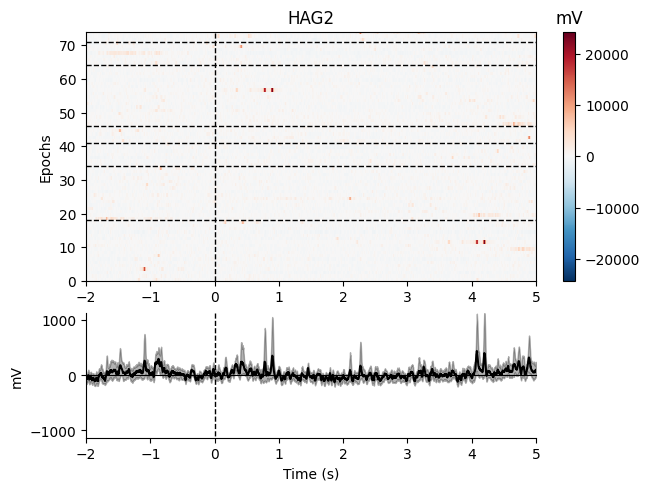

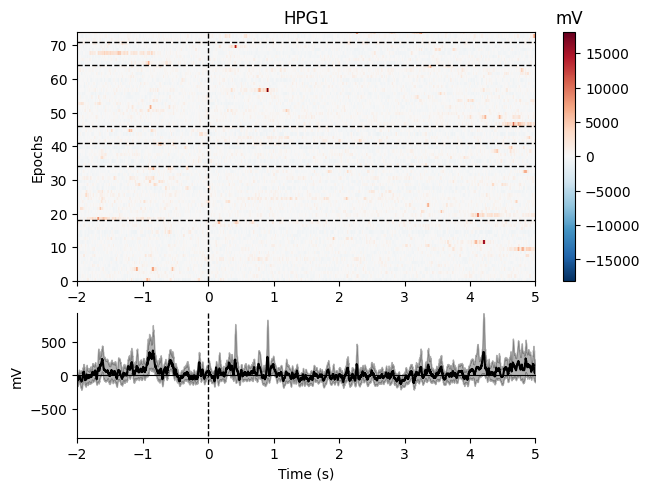

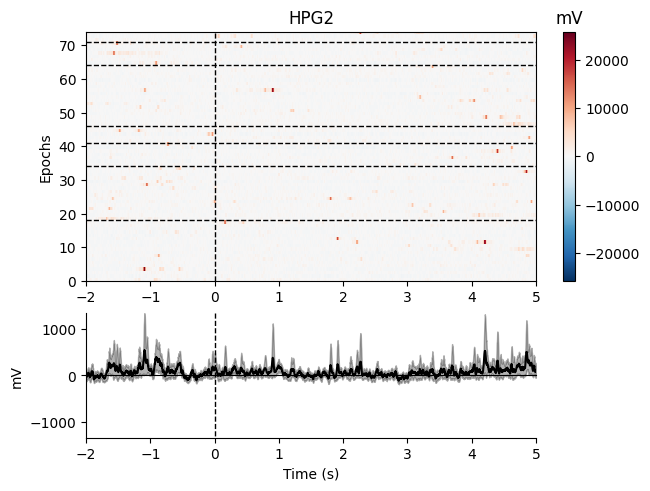

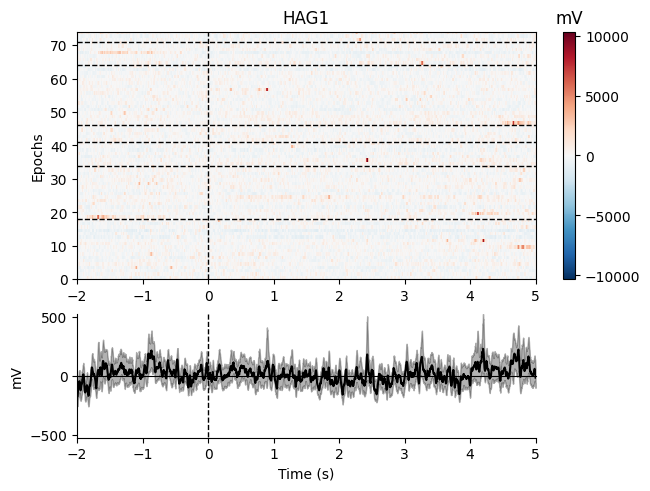

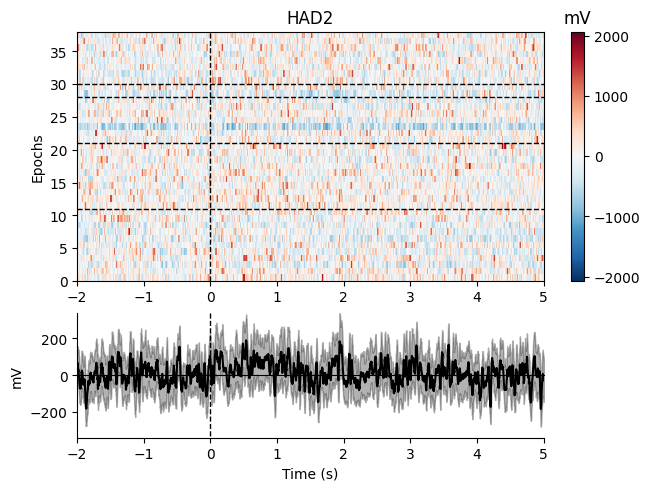

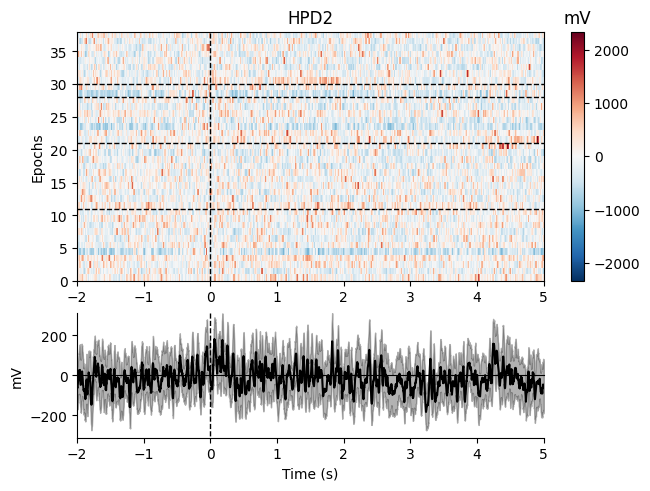

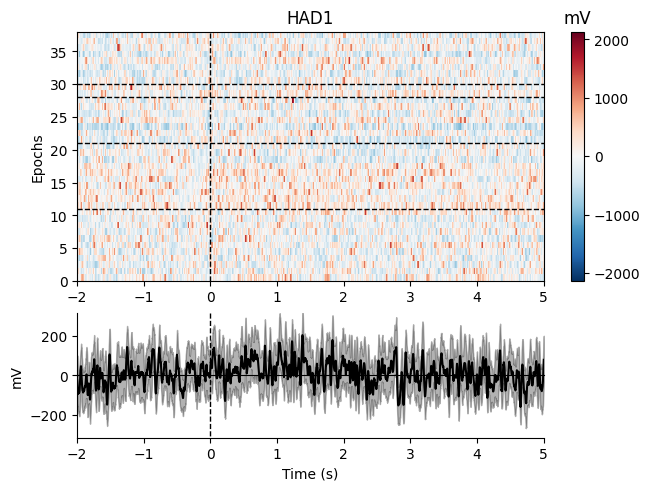

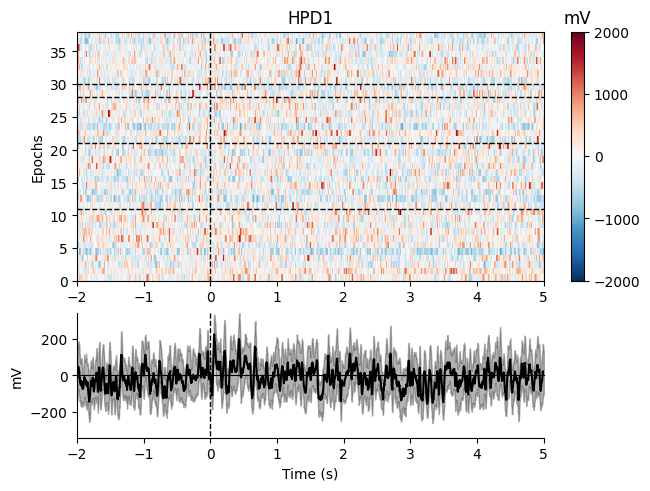

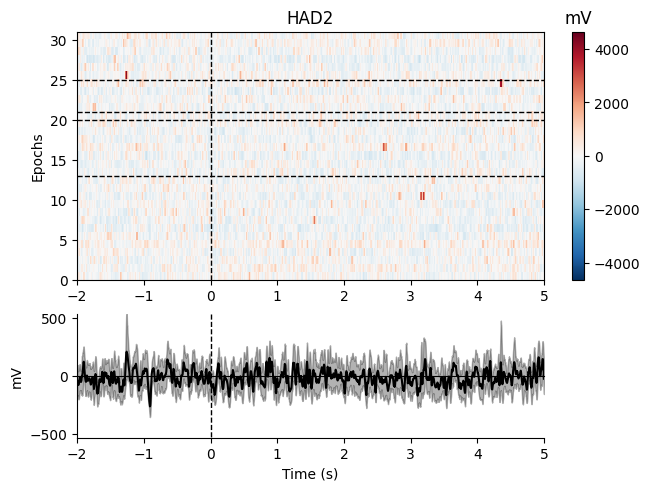

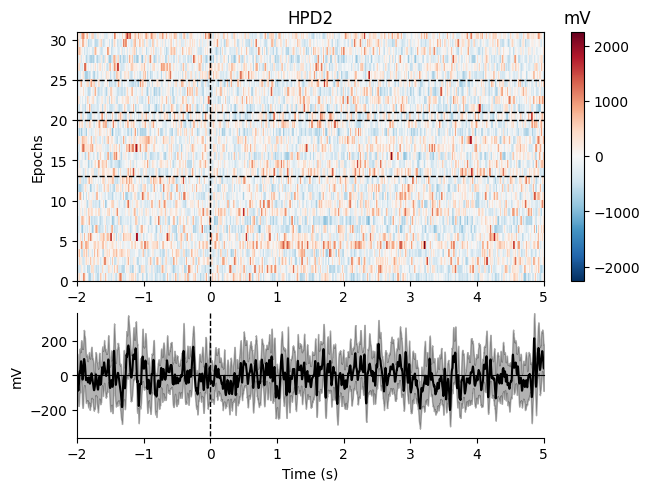

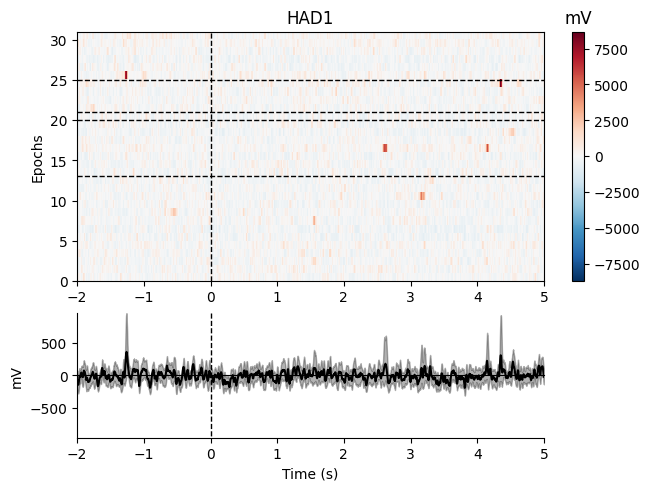

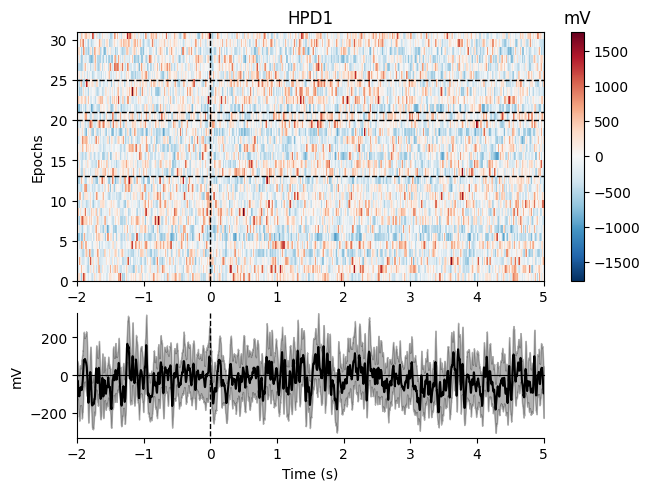

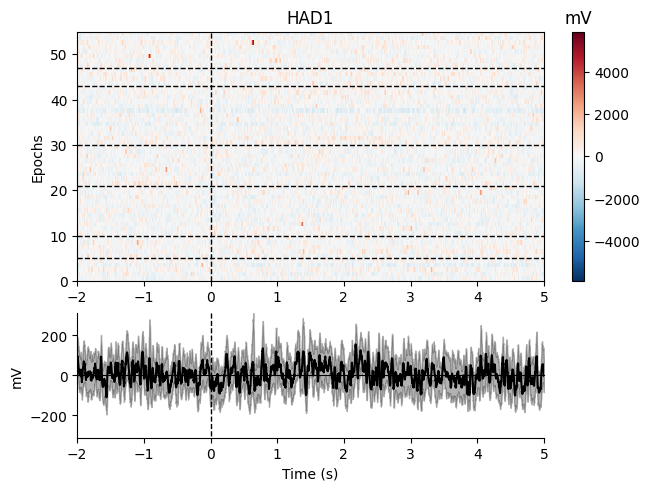

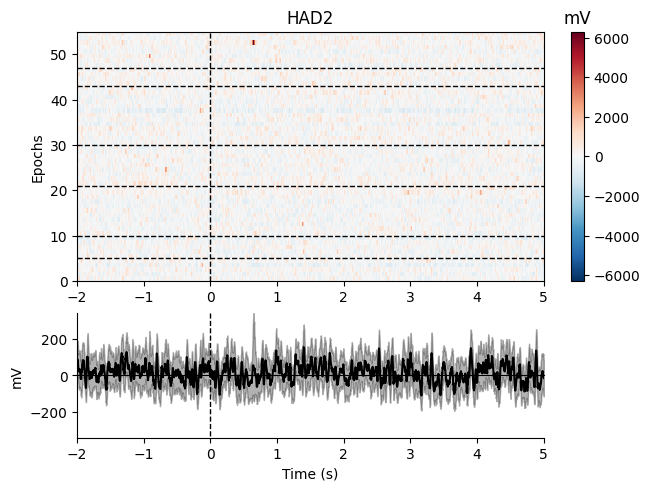

In [35]:
import os
import numpy as np
import mne

from mne import Epochs
from mne.time_frequency import EpochsTFRArray
from mne_bids import (
    find_matching_paths,
    read_raw_bids,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import find_anodes_cathodes


n_jobs = 12
bids_root = os.path.abspath("../..")
subjects = ["01", "02", "03", "04"]

tmin = -2
tmax = 5


freqs = np.arange(90, 150.0, 5) 
bandwidth =  5

for subject in subjects:
    bids_path = find_matching_paths(
        subjects=subject, sessions="retrieval", tasks="mars", datatypes="ieeg", extensions="vhdr", root=bids_root
    )[0]
    raw = read_raw_bids(bids_path=bids_path, verbose=False)

    # load events
    events_path = bids_path.copy().update(extension="tsv", suffix="events")
    df_events = pd.read_csv(events_path, sep="\t")
    df_events = df_events[(df_events['correct'] == True) & (df_events['duration'] < 5)]
    events = df_events[["sample", "duration", "value"]].to_numpy()
    events[:, 1] = 0
    events = events.astype(int)
    event_id = dict(zip(df_events['condition'], df_events['value']))

    # annotations
    annotations_path = str(bids_path.fpath)[:-9] + "annot.csv"
    annotations = mne.read_annotations(annotations_path)
    raw.set_annotations(annotations)

    picks = None
    if "HAD1" in raw.ch_names:
        picks = ['HAD1', 'HAD2', 'HPD1', 'HPD2']
    elif "HAG1" in raw.ch_names:
        picks = ['HAG1', 'HAG2', 'HPG1', 'HPG2']
    else:
        raise ValueError("No channel found in the data.")
    picks = list(set(picks).intersection(set(raw.ch_names))) 
    raw.load_data()

    # filter
    raw.filter(.1, 250, picks='seeg', fir_design='firwin', n_jobs=n_jobs, verbose=False)
    # remove power line 50 Hz and harmonics
    raw.notch_filter(np.arange(50, 251, 50),
                    picks='seeg', 
                    notch_widths=4,
                    n_jobs=n_jobs,
                    verbose=False)


    good_channels = list(set(raw.ch_names) - set(raw.info['bads']) - set(['photodiode']))
    raw.set_eeg_reference(good_channels, ch_type='seeg')

    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(-0.5, 0),  detrend=1, event_repeated='raise', reject_by_annotation=True).load_data()

    data = np.zeros(
        (len(epochs), len(picks), freqs.size, int((tmax - tmin) * raw.info['sfreq']) + 1), dtype=complex
    )
    data_norm = np.zeros(
        (len(epochs), len(picks), freqs.size, int((tmax - tmin) * raw.info['sfreq']) + 1), dtype=complex
    )
    for idx, freq in enumerate(freqs):
        # Filter raw data and re-epoch to avoid the filter being longer than
        # the epoch data for low frequencies and short epochs, such as here.
        raw_filter = raw.copy()
        raw_filter.pick(picks)
        raw_filter.filter(
            l_freq=freq - bandwidth / 2,
            h_freq=freq + bandwidth / 2,
        )
        raw_filter.apply_hilbert() # power 
        epochs_hilb = Epochs(
            raw_filter, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, event_repeated='raise', reject_by_annotation=True).load_data()
        data[:, :, idx] = epochs_hilb.get_data(picks)

    power_data = np.abs(data)# ** 2 # Puissance instantanée
    power_norm_data = power_data / np.mean(power_data, axis=-1, keepdims=True) # Norm

    power = EpochsTFRArray(epochs_hilb.info, power_data, epochs.times, freqs, events=epochs_hilb.events, event_id=event_id, method="hilbert")
    power_norm = EpochsTFRArray(epochs_hilb.info, power_norm_data, epochs.times, freqs, events=epochs_hilb.events, event_id=event_id, method="hilbert")


    sequence = []
    condition_order = ['Never', 'Always', 'Distant Past', 'Past', 'Current', 'Futur', 'Distant Futur']
    for condition in condition_order:
        if condition in epochs.event_id.keys():
            sequence.append(epochs.event_id[condition])

    order = get_reordered_indices(epochs_hilb.events[:,2], sequence)
    h_lines_y = np.where(np.diff(epochs_hilb.events[order][:,2]) != 0)[0]

    data_ = np.mean(power_norm.get_data(picks), axis=2)
    epoch_high_freq = mne.EpochsArray(data_, epochs_hilb.info, tmin=epochs_hilb.times[0], events=epochs_hilb.events, event_id=event_id, baseline=None)
    epoch_high_freq.apply_baseline((-0.5, -0.1))

    for pick in picks:
        fig = epoch_high_freq.plot_image(picks=pick, order=order, show=False)[0]
        ax = fig.get_axes()[0]
        for y in h_lines_y:
            ax.hlines(y, *ax.get_xlim(), color='black', linestyle='--', linewidth=1)
        fig.savefig(f"figures/{subject}_{pick}_high_freq.png", dpi=300)
